In [5]:
# --- 咖啡豆類型選擇區塊（全 notebook 共用）---
bean_type = "kenya_natural"  # 可選："ethiopia_washed", "kenya_natural", "honduras_natural"
input_folder = f"coffee_beans_data/{bean_type}/coffee_beans_photo"
output_folder_good = f"coffee_beans_data/{bean_type}/crop/classByhands/good"
output_folder_bad = f"coffee_beans_data/{bean_type}/crop/classByhands/bad"
output_folder_idontknow = f"coffee_beans_data/{bean_type}/crop/classByhands/idontknow"

import cv2
import numpy as np
import os
import glob

# 建立輸出資料夾
os.makedirs(output_folder_good, exist_ok=True)
os.makedirs(output_folder_bad, exist_ok=True)
os.makedirs(output_folder_idontknow, exist_ok=True)

# 清空資料夾內的舊檔案
for folder in [output_folder_good, output_folder_bad, output_folder_idontknow]:
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))

需要針對照片大小去調整的參數有

    if 1000 < area < 40000 and 0.3 < aspect_ratio < 2:
        filtered_contours.append(contour)

40000 跟 橢圓比2 可能需要調整

In [6]:
# 取得所有圖片路徑
image_paths = glob.glob(os.path.join(input_folder, "*.jpg")) + glob.glob(os.path.join(input_folder, "*.jpeg"))

if len(image_paths) == 0:
    raise FileNotFoundError(f"找不到 {input_folder} 下的 jpg/jpeg 檔案")

# 建立輸出資料夾
os.makedirs(output_folder_good, exist_ok=True)

# 清空資料夾內的舊檔案
for f in os.listdir(output_folder_good):
    os.remove(os.path.join(output_folder_good, f))

bean_count = 0

for img_idx, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        if 1000 < area < 40000 and 0.3 < aspect_ratio < 2:
            filtered_contours.append(contour)

    for i, contour in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(contour)
        bean_crop = image[y:y+h, x:x+w]
        bean_path = os.path.join(output_folder_good, f"bean_{bean_count}.jpg")
        cv2.imwrite(bean_path, bean_crop)
        bean_count += 1

print(f"✅ 共偵測到 {bean_count} 顆咖啡豆，已儲存於 '{output_folder_good}' 資料夾！")


✅ 共偵測到 325 顆咖啡豆，已儲存於 'coffee_beans_data/kenya_natural/crop/classByhands/good' 資料夾！


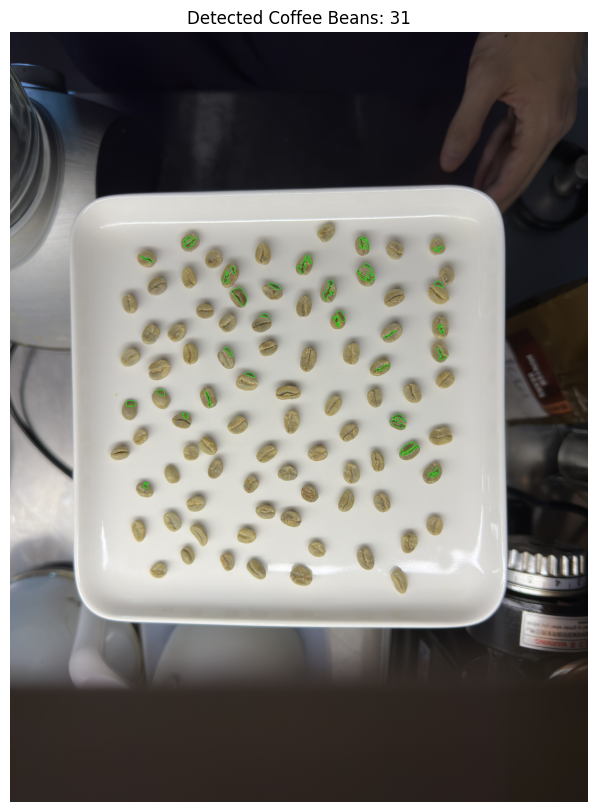

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# 取得所有圖片路徑
image_paths = glob.glob(os.path.join(input_folder, "*.jpg")) + glob.glob(os.path.join(input_folder, "*.jpeg"))
# 這裡以第一張圖片為例
if len(image_paths) == 0:
    raise FileNotFoundError(f"找不到 {input_folder} 下的 jpg/jpeg 檔案")
image_path = image_paths[0]
image = cv2.imread(image_path)

# 轉換為灰階
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 使用高斯模糊降低噪聲
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

# 二值化處理（Otsu 門檻處理）
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 應用形態學運算來去除小的雜訊
kernel = np.ones((5, 5), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# 重新偵測輪廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 過濾輪廓：根據面積大小 & 橢圓度
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h  # 計算長寬比
    area = cv2.contourArea(contour)

    if 1000 < area < 40000 and 0.3 < aspect_ratio < 2:
        filtered_contours.append(contour)

# 在原圖上畫出檢測到的輪廓
output_image = image.copy()
cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 2)

# 顯示處理後的影像
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Detected Coffee Beans: {len(filtered_contours)}")
plt.show()